In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from tqdm import tqdm

from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter, resample_to_delta_t
from pycbc.vetoes import power_chisq



import sys
home_dir = r'/home/shrey/Desktop/IUCAA-Project/'
sys.path.insert(0, home_dir)
from snrs import SNR

## Path for Dataset
path = ''
sys.path.insert(0, path)
from snrs import SNR

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [13]:
## Function to get Horizon Distance:

strain = pd.read_csv(path + 'H_200.csv')
strain = TimeSeries(np.array(strain['H']), delta_t = 1/4096)
strain = resample_to_delta_t(strain, delta_t=1/256)
strain.start_time=0

def SNR_8(temp, Data=strain, method='reg'):
    
    """
    Docstring:
    
    Find the Horizon Distance in log10 units
    
    temp (type: pycbc.types.timeseries.TimeSeries):                                         Waveform template
    method (type: str, Default = 'reg'):                                                    'reg' for SNR, 'new' for NEWSNR
    """
    
    i = 0 # initial distance (source and detector)
    itt = 2 # will itterate as 10**(itt) or 1/10**(itt)

    # check if Dh = 6 (1 Mpc) is alreadt the horizon distance for this template
    snr = SNR(temp, Data=Data, inject_time=100, method=method)
    if snr > 7.5 and snr < 8.5:
        return i
    
    # if snr is lower than 7.5, then keep reducing the lumin Distance by 10**2. When the snr crosses 8.5, then lower the itterator by half.
    # At that point, we will reduce the Lumin Distance by 10**1 instead of 10**2. When SNR is finally between 7.5 and 8.5, the loop stops.
    if snr < 7.5:
        keep = True
        while keep:
            i -= itt
        
            snr = SNR(temp/10**i, Data=Data, inject_time=100, method=method)
        
            if snr > 8.5:
                i += itt
                itt /= 2
        
            if snr > 7.5 and snr < 8.5:
                keep = False
            
                return i
    
    # same if the snr is more than 8.5. Here the Lumin Distance is increased instead of decreased.
    if snr > 8.5:
        keep = True
        while keep:
            i += itt
        
            snr = SNR(temp/10**i, Data=Data, inject_time=100, method=method)
        
            if snr < 7.5:
                i -= itt
                itt /= 2
        
            if snr > 7.5 and snr < 8.5:
                keep = False
            
                return i

In [14]:
read = h5py.File(path + 'Samples.hdf5', 'r')
H11 = read['H11']
H12 = read['H12']
H22 = read['H22']

In [15]:
df = pd.DataFrame()
for j in read.attrs.keys():
    df[j] = list(read.attrs[j])

df['Dh'] = np.zeros(df.shape[0])
df['snr'] = np.zeros(df.shape[0])
df['newsnr'] = np.zeros(df.shape[0])

Masses = df['M'].unique()

tot = len(Masses)
mnum = 0
for M in Masses:
    dm = df[df['M'] == M].copy()
    
    mnum += 1
    for i, z in zip(range(dm.shape[0]), tqdm(range(dm.shape[0]), desc="Loading (" + str(mnum) + "/" + str(tot) + ")" )):
        
        j = dm.iloc[i].copy()
        
        ids = int(j['id'])
        hp = np.array(H11[str(ids)]) - np.array(H22[str(ids)])
        hp = TimeSeries(hp, delta_t=1/256)
        hp.start_time=0
        
        if ids == 18200: # exception
            POW = np.log10(1850000)
        else:
            POW = SNR_8(hp)
        Dh = 10**POW
        
        hp = hp/Dh
        snr = SNR(hp, Data=strain, inject_time=100)
        newsnr = SNR(hp, Data=strain, inject_time=100, method='new')
        
        df.at[ids, 'Dh'] = np.log10(Dh)
        df.at[ids, 'snr'] = snr
        df.at[ids, 'newsnr'] = newsnr

Loading (4/4):  98%|███████████████████████████▌| 58/59 [01:17<00:01,  1.34s/it]


Save the data and see if the SNRs make sense

In [16]:
df.head(5)

,M,Qi,id,ri,Dh,snr,newsnr
0,1,-6.027794,0,4.958728,-3.8125,8.137289,7.790414
1,1,-5.262685,1,5.777938,-5.6875,8.404800,7.957240
2,1,-4.029232,2,1.271741,-6.5000,8.336715,7.478269
3,1,-6.043304,3,3.200319,-3.3750,7.740130,7.433067
4,1,-5.024806,4,0.836004,-4.2500,7.636446,7.325091


In [4]:
df.to_csv(path + 'Horizon.csv', index=False)
print(df['snr'].describe(), df['newsnr'].describe())

count    236.000000
mean       7.980429
std        0.281686
min        7.504760
25%        7.748187
50%        7.972790
75%        8.222427
max        8.499672
Name: snr, dtype: float64 count    236.000000
mean       7.465508
std        0.517035
min        5.634823
25%        7.226609
50%        7.612388
75%        7.868704
max        8.496602
Name: newsnr, dtype: float64


## Plotting the Param space with horizon distance

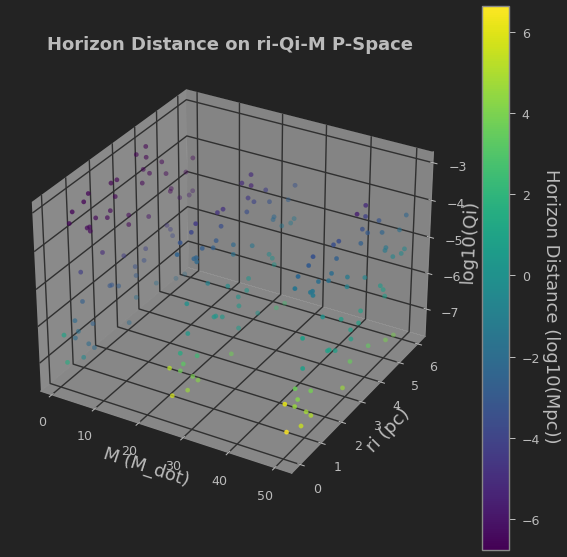

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

DF = df[df['M'] != 10]

p = ax.scatter(DF['M'], DF['ri'], DF['Qi'], c=DF['Dh'])#, norm=matplotlib.colors.LogNorm(vmin=DF['lDh'].min(), vmax=DF['lDh'].max()))
cbar = fig.colorbar(p, ax=ax)

cbar.set_label('Horizon Distance (log10(Mpc))', fontsize=18, rotation=270,labelpad=20, y=0.45)

ax.set_ylabel('ri (pc)', fontsize=18)
ax.set_zlabel('log10(Qi)', fontsize=18)
ax.set_xlabel('M (M_dot)', fontsize=18)
ax.set_title('Horizon Distance on ri-Qi-M P-Space', fontsize=18, fontweight='bold')
plt.show()

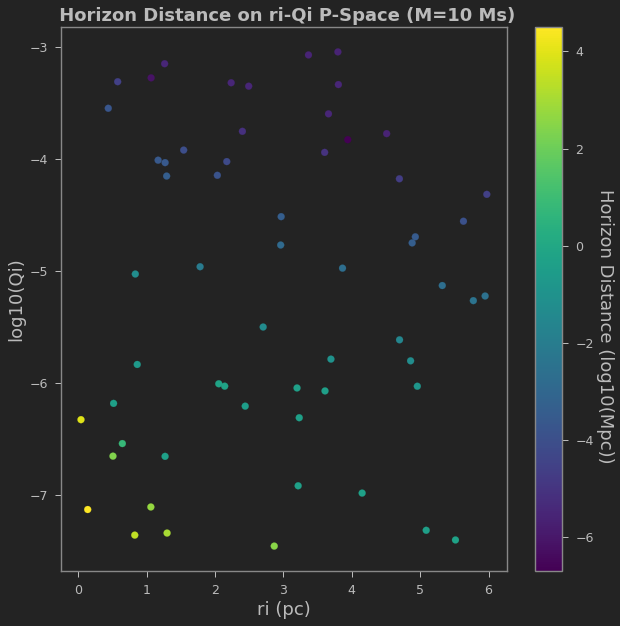

In [8]:
import matplotlib

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

DF = df[df['M'] == 10].copy()
p = ax.scatter(DF['ri'], DF['Qi'], c=DF['Dh'])#, norm=matplotlib.colors.LogNorm(vmin=DF['lDh'].min(), vmax=DF['lDh'].max()))
cbar = fig.colorbar(p, ax=ax)

cbar.set_label('Horizon Distance (log10(Mpc))', fontsize=18, rotation=270,labelpad=20, y=0.45)

ax.set_xlabel('ri (pc)', fontsize=18)
ax.set_ylabel('log10(Qi)', fontsize=18)
ax.set_title(' Horizon Distance on ri-Qi P-Space (M=10 Ms)', fontsize=18, fontweight='bold')
plt.show()